In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import warnings
from statsmodels.tsa.deterministic import DeterministicProcess

warnings.filterwarnings('ignore')

def getDfs():
    holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=True)
    oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=True)
    stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv', parse_dates=True)
    train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=True, index_col='id')
    test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=True, index_col='id')
    transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=True)
    
    return holidays, oil, stores, train, test, transactions


def getX():
    holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=True)
    oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=True)
    stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv', parse_dates=True)
    train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=True, index_col='id')
    test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=True, index_col='id')
    transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=True)
    
    # Unisco train e test per poter mergiare le altre colonne - Inferenza
    X = pd.concat([train, test], axis=0)
    # transactions# Provo ad inserire il transactions lag_1 dello store
    # visto che c'è correlazione con il giorno precedente normalmente
    #transactions['transactions_lag1'] = transactions['transactions'].shift(0).fillna(0)
    #X = train.copy()
    X = pd.merge(X, stores[['store_nbr', 'type', 'cluster']], on='store_nbr', how='left')
    X = pd.merge(X, transactions[['date', 'store_nbr', 'transactions']], on=['date','store_nbr'], how='left')
    X = pd.merge(X, oil[['date', 'dcoilwtico']], on='date', how='left')
    X = pd.merge(X, holidays[['date', 'type', 'transferred']], on='date', how='left')    
    X['date'] = pd.to_datetime(X['date'])
    
    #X = X[X['date']>pd.to_datetime('2015-12-31')]

    return X, test

def getTrainTest():
    train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=True, index_col='id')
    test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=True, index_col='id')
    
    X = train.copy()
    X['date'] = pd.to_datetime(X['date'])
    test['date'] = pd.to_datetime(test['date'])

    # Prendiamo solamente le date oltre 2015
    #X = X[X['date']>pd.to_datetime('2015-12-31')]
    #test =test[test['date']>pd.to_datetime('2015-12-31')]
    
    return X, test

def getXLagged():
    train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=True, index_col='id')
    test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=True, index_col='id')
    
    train['Lag_1'] = train['sales'].shift(1).fillna(0)

    return train, test

def getGrouped(family, target, X=None):
    if X is None:
        X, _ = getX()
    XX = X[X['family']==family].groupby('date')[target].sum().reset_index()
    X['date'] = pd.to_datetime(X['date'])

    return XX

from sklearn.preprocessing import LabelEncoder
def labelEncodeFeatures(X, features=None):
    if features is None:
        features = [feat for feat in X.columns if X[feat].dtype=='object']
    for feature in features:
        label_encoder = LabelEncoder()
        X[feature] = label_encoder.fit_transform(X[feature])
    return 

# WINDOWING, studio dell'orizzonte temporale: DEEP LEARNING
In base al tipo di previsione studiamo qual è l'orizzonte temporale, definiamo:
* **Input width**: quanti dati determinano la previsione
* **offset**: qual è la distanza della previsione da fare dai dati disponibili in termini di step temporali
* **label width**: l'ampiezza della previsione che deve essere effettuata in termini di step temporali

**CLASSE WINDOW GENERATOR**
* shift è la distanza tra l'input e la fine delle label --> total_window_size = input_width + shift
  

In [3]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df, val_df=None, test_df=None,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift 
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        

    def split_window(self, features, scale=False):
        inputs = features[:, self.input_slice, :]
        if scale:
            min_val = tf.reduce_min(inputs, axis=0)
            max_val = tf.reduce_max(inputs, axis=0)
            print(f'min_val:{min_val}')
            print(f'max_val:{max_val}')
            inputs = (inputs - min_val) / (max_val - min_val)

        
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
    
        return inputs, labels

    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
        
    # Istanziando la classe ho un df, una window, le label e le features
    # Per i modelli di deeplearning occorre un tensore (n_finestre_temporali_disponibili, n_timesteps, features) 
    # Questo perchè il modello deve predire un risultato basandosi su n_timesteps. Questi n_timesteps sono raccolti sul
    # totale dei dati a disposizione, quindi abbiamo una finestra temporale che si sposta ogni volta di un timestep alla volta
    # La difficoltà nel nostro caso è dovuta al fatto che ogni coppia store/famiglia prodotto produce un tensore diverso
    def split_data_for_tensor(self, df, features, target):
        import tensorflow as tf
        # Calcolo quante finestre temporali si possono generare dai dati a disposizione.
        # Questo sarà la prima dimensione del tensore
        if df is None:
            df = self.train_df
        if features is None:
            features = self.train_df.columns
            
        n_timesteps = df.shape[0]
        n_available_windows = n_timesteps - self.total_window_size
    
        feature_index = [df.columns.get_loc(feature_name) for feature_name in features]
        target_index = [df.columns.get_loc(target_name) for target_name in target]
        self.label_indices = target_index # Serve poi per disegnare il plot
        #print(f'self.label_indices:{self.label_indices}')
        # Per ogni coppia store/famiglia creo n_finestre_temporali di 6 timesteps e n_features
        tensor_input = np.zeros((n_available_windows, self.input_width, len(features)))
        tensor_label = np.zeros((n_available_windows, self.label_width, len(target)))
    
        for i in range(n_available_windows):
            # Vado ad affettare il df raccogliendo le features: devo creare pacchetti di self.input_width X n_features
            # Isolo i dati della finestra
            start_window = i
            end_window = i + self.input_width + self.label_width
            
            square_input = df.iloc[start_window:start_window + self.input_width, feature_index]
            square_label = df.iloc[end_window - self.label_width:end_window, target_index]
            tensor_input[i] = square_input
            tensor_label[i] = square_label
       
        return tf.convert_to_tensor(tensor_input, dtype=tf.float32), tf.convert_to_tensor(tensor_label, dtype=tf.float32)

    @property
    def train(self):
      return self.make_dataset(self.train_df)
    
    @property
    def val(self):
      return self.make_dataset(self.val_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)

    
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    
      ds = ds.map(self.split_window)
    
      return ds    
    # Plot dei dati

    def plot(self, X,  y, prediction=None, predictions_fourier=None, plot_col='sales', n_subplots=3, offset_window = 0, model=None):
        from matplotlib.lines import Line2D
        import matplotlib.pyplot as plt
        input_slice = slice(0, self.input_width)
        input_indices = np.arange(self.total_window_size)[input_slice] 
        
        label_start = self.total_window_size - self.label_width
        labels_slice = slice(label_start, None)
        label_indices = np.arange(self.total_window_size)[labels_slice] 
        
        plot_col_index, = self.label_indices #Un list di un solo valore: eseguo unpacking
        label_col_index = 0
        
        plt.figure(figsize=(12, 8))
        # Plotta la parte di input
        for n in range(n_subplots):
            indx = n + offset_window
            plt.subplot(n_subplots, 1, n+1)
            legenda = []
            plt.plot(input_indices, X[indx, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-19)
            custom_label_marker = Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Label value')               
            legenda.append(custom_label_marker)
            plt.scatter(label_indices, y[indx, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64,  zorder=-3)
            if prediction:
                custom_star_marker = Line2D([0], [0], marker='*', color='w', markerfacecolor='orange', markersize=10, label='Prediction model')               
                legenda.append(custom_star_marker)
                plt.plot(label_indices, prediction,
                         label='Prediction model', marker='*', zorder=-2)
            if predictions_fourier:
                custom_square_marker = Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Prediction fourier')               
                legenda.append(custom_square_marker)
                plt.plot(label_indices, predictions_fourier,
                         label='Prediction fourier', marker='s', zorder=-1)

            plt.legend(handles=legenda)
                
        
        
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    
      ds = ds.map(self.split_window)
    
      return ds




# Eseguo lo split del DF in pacchetti di tensori per il fit

Provo il window generator.Imposto 
* la profondità temporale dell'input (input_width)
* la profondità temporale della label (label_width)
* la distanza temporale tra input e fine della finestra (shift)

# BASELINE
Settiamo una baseline. 
Visto che c'è una stagionalità possiamo settare come baseline le previsioni con modello lineare allenato su un deterministic process

# CREAZIONE MODELLO LINEARE CHE APPROSSIMA CON FOURIER

In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
def addFourierToTrain(series):
    series = series.sort_values(by='date').reset_index(drop=True)
    # Imposta la colonna 'date' come indice
    series = series.set_index('date')
    # Devo accertarmi che l'indice non abbia buchi
    #series.index.freq = pd.DateOffset(days=1)

    fourier = CalendarFourier(freq='M', order=4)
    
    dp = DeterministicProcess(
        constant=True,
        index=series.index,
        order=1,
        seasonal=True,
        drop=True,
        additional_terms=[fourier],
    )
    
    X_sample_fourier = dp.in_sample()  
    series = pd.concat([series,X_sample_fourier], axis=1)
    return series

def addCrhistmas(series):
    existing_value = series[series.date == pd.to_datetime('2013-12-26')].copy()
    existing_value.date = pd.to_datetime('2013-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2014-12-26')].copy()
    existing_value.date = pd.to_datetime('2014-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2015-12-26')].copy()
    existing_value.date = pd.to_datetime('2015-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2016-12-26')].copy()
    existing_value.date = pd.to_datetime('2016-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    return series

# correggo i NaN di dcoilwtico prendendo il valore NaN più vicino
def fill_nan_with_nearest(arr):
    filled_arr = arr.copy()
    mask = np.isnan(filled_arr)    
    for i in range(1, len(filled_arr)):
        if mask[i]:
            filled_arr[i] = filled_arr[i-1]  # Sostituisci con il valore precedente non NaN

    for i in range(len(filled_arr) - 2, -1, -1):
        if mask[i]:
            filled_arr[i] = filled_arr[i+1]  # Sostituisci con il valore successivo non NaN

    return filled_arr

# Se voglio utilizzare i tempi precedenti come input devo creare i lag da t0 a t_n
def createLags(X, target, n_lags):
    lags = {f'lag_{i}': X[target].shift(i) for i in range(1,n_lags+1)}
    lags_df = pd.DataFrame(lags)
    X = pd.concat([X, lags_df], axis=1)
    return X


In [5]:
def addFeaturesToTrain(series):
    holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=True)
    oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=True)
    holidays['date'] = pd.to_datetime(holidays['date'])
    oil['date'] = pd.to_datetime(oil['date'])
    #series = series.reset_index()
    series = pd.merge(series, oil[['date', 'dcoilwtico']], on='date', how='left')
    series = pd.merge(series, holidays[['date', 'type', 'transferred']], on='date', how='left')    
    labelEncodeFeatures(series)
    return series

def CreateSeriesDf():
    grouping = 'LIQUOR,WINE,BEER'
    series = getGrouped(grouping, 'sales')
    series = addCrhistmas(series)
        
    # Decidiamo i dati da passare al modello.
    # Sicuramente i dati periodici
    # Vediamo gli altri dati delle tabelle collegabili
    series = addFourierToTrain(series)
    series = addFeaturesToTrain(series)
    series = createLags(series, 'sales', 6)
        
    return series
    

In [6]:
# modello con deterministic process
#series = getGrouped('PREPARED FOODS', 'sales')
def step1(grouping):
    
    series = getGrouped(grouping, 'sales')
    
    # c'è un probelma di date inesistenti, inserisco le date di natale copiandole dal santostefano
    existing_value = series[series.date == pd.to_datetime('2013-12-26')].copy()
    existing_value.date = pd.to_datetime('2013-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2014-12-26')].copy()
    existing_value.date = pd.to_datetime('2014-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2015-12-26')].copy()
    existing_value.date = pd.to_datetime('2015-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    existing_value = series[series.date == pd.to_datetime('2016-12-26')].copy()
    existing_value.date = pd.to_datetime('2016-12-25')
    existing_value.sales = 0
    series = pd.concat([series, existing_value], ignore_index=True)
    
    # Feature engeneering sulle date
    year = (365.2425)
    #series['Year sin'] = np.sin(series['date'].dt.dayofyear * (2 * np.pi / year))
    #series['Year cos'] = np.cos(series['date'].dt.dayofyear * (2 * np.pi / year))
    return series
    


In [7]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
def step2(grouping):
    series = step1(grouping)
    '''
    fourier = CalendarFourier(freq="A", order=8)  # 12 sin/cos pairs for "A"nnual seasonality
    dp = DeterministicProcess(
                index=series.index,  
                constant=True,     
                order=1,           
                seasonal=True,     # stagionalità settimanale gestita con gli indicators
                additional_terms=[fourier],  # stagionalità annuale (fourier)
                drop=True,        
            )
    '''
    # Ordino per data e ri-indicizzo
    series = series.sort_values(by='date').reset_index(drop=True)
    # Imposta la colonna 'date' come indice
    series = series.set_index('date')
    #series.index.freq = pd.DateOffset(days=1)
    fourier = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        constant=True,
        index=series.index,
        order=1,
        seasonal=True,
        drop=True,
        additional_terms=[fourier],
    )
    
    X_sample_fourier = dp.in_sample()  
    return X_sample_fourier, series

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def step3(grouping):
    X_sample_fourier, series = step2(grouping)
    # Per allenare un modello lineare occorre prima capire quali sono le label.
    # Dato il X_sample_fourier abbiamo a disposizione come chiave la data
    series = series.reset_index()
    X_fourier = pd.merge(series, X_sample_fourier, on='date', how='left')
    X_fourier = X_fourier.set_index('date')
    y_fourier = X_fourier.pop('sales')
    
    categoric_features = [col for col in X_fourier.columns if X_fourier[col].dtype=='object']
    labelEncodeFeatures(X_fourier, categoric_features)
    
    X_train, X_val, y_train, y_val = train_test_split(X_fourier, y_fourier, test_size=0.2, random_state=42)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)
    return X_sample_fourier, X_fourier, y_fourier, series, model

In [9]:
import pandas as pd # data processing

grouping = 'LIQUOR,WINE,BEER'
X_sample_fourier, X_fourier, y_fourier, series, model_fourier = step3(grouping)

period_pred = slice(1000, 1200)
from_x = period_pred.start
to_x = period_pred.stop
predictions = model_fourier.predict(X_fourier[period_pred])
predictions_df = pd.DataFrame({
    'id': range(from_x, to_x),
    'predicted_sales': predictions  
})
predictions_df = predictions_df.set_index('id')

XXX = pd.concat([X_fourier, y_fourier], axis=1)

unperioded_data = pd.concat([XXX.reset_index(), predictions_df], axis=1)
unperioded_data['unperioded'] = unperioded_data['sales']-unperioded_data['predicted_sales']
unperioded_data = unperioded_data[period_pred]


Mean Squared Error: 9708360.196021715
R^2 Score: 0.42217622813624467


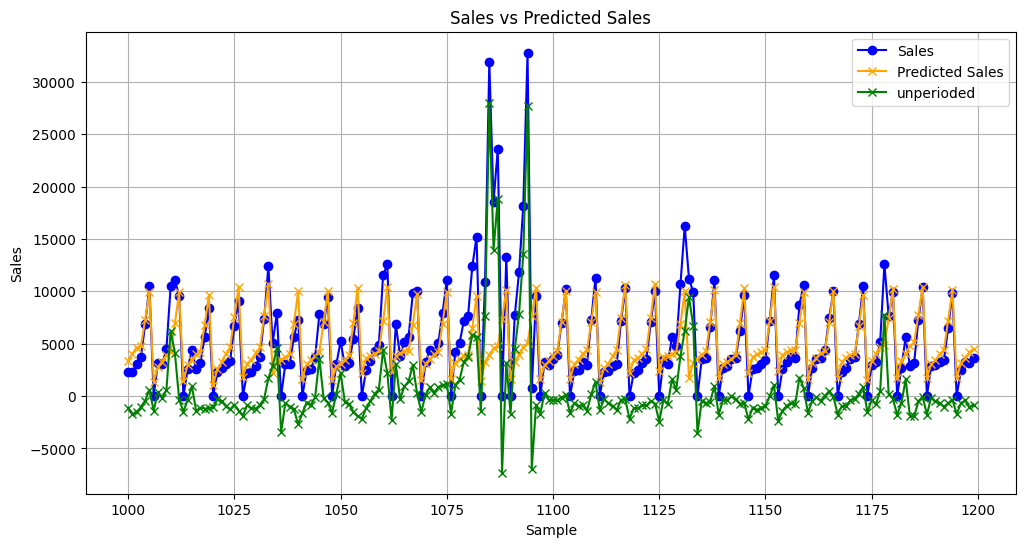

In [10]:
import matplotlib.pyplot as plt
# Crea il grafico
plt.figure(figsize=(12, 6))
plt.plot(unperioded_data['sales'], label='Sales', color='blue', marker='o')
plt.plot(unperioded_data['predicted_sales'], label='Predicted Sales', color='orange', marker='x')
plt.plot(unperioded_data['unperioded'], label='unperioded', color='green', marker='x')

# Aggiungi titoli e leggenda
plt.title('Sales vs Predicted Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

Possiamo **aggiungere un livello** e processare ulteriormente i dati:
* Sottraiamo l'andamento di fourier dalla serie, in questo modo otteniamo una serie più regolare
* Con il risultato alleniamo un modello RandomForest oppure XGBoost per lavorare con le features (nel nostro caso sostanzialmente i lag fino al sesto giorno)

# LIVELLO XGBoost

In [11]:
import numpy as np # linear algebra
import xgboost as xgb

grouping = 'LIQUOR,WINE,BEER'
total = X_fourier.shape[0]
train = int(total * 0.7)
val = int(total * 0.2)

train_slice = slice(0, train)
train_fourier = X_fourier[train_slice]
print(f'train_fourier shape:{train_fourier.shape}')

# Ora occorre concatenare gli unperioded data ai dati arricchiti
df = series.copy()
df = addFeaturesToTrain(df)
df = createLags(df, 'sales', 6)
df['dcoilwtico'] = fill_nan_with_nearest(df['dcoilwtico'])
# Separo train validation e test
df_train = df.iloc[:train]
df_val = df.iloc[train:train+val]
df_test = df.iloc[train+val:]

# Costruisco tutte le predizioni per il periodo di training
predictions = model_fourier.predict(train_fourier)
predictions_df = pd.DataFrame({
    'predicted_sales': predictions  
})
residuals = pd.concat([df_train.reset_index(), predictions_df], axis=1)
residuals['unperioded'] = residuals['sales']-residuals['predicted_sales']
residuals = residuals.drop(['index','predicted_sales'], axis=1)
real_y = residuals.pop('sales')

# Ora alleno il modello XGBoost sul residual del primo modello
residuals = residuals.set_index('date')
y = residuals.pop('unperioded')
X = residuals.copy()
boost_model = xgb.XGBRegressor()
boost_model.fit(X, y)

y_pred_residuals = boost_model.predict(X)
y_final = predictions + y_pred_residuals

train_fourier shape:(1192, 16)


In [12]:
period_pred = slice(0, len(y_final))
from_x = period_pred.start
to_x = period_pred.stop

predictions_final = pd.DataFrame({
    'id': range(from_x, to_x),
    'predicted_sales': y_final  
})
X = X.reset_index()
X = pd.concat([X,real_y], axis=1)
predictions_final = predictions_final.set_index('id')
XXX = pd.concat([X, predictions_final], axis=1)

final_data = pd.concat([XXX.reset_index(), predictions_final], axis=1)



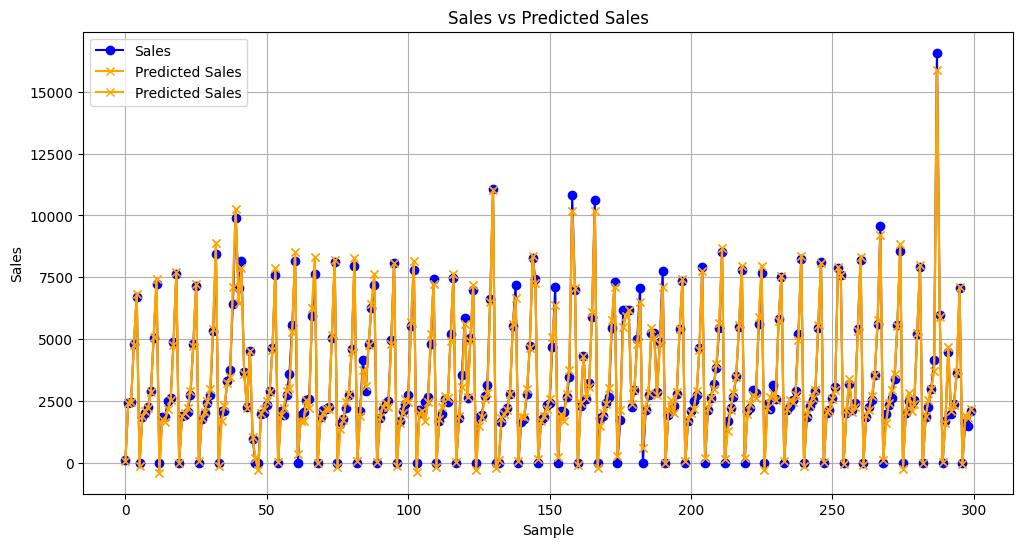

In [13]:
import matplotlib.pyplot as plt
period_plot = slice(0,300)
data_to_plot = final_data[period_plot]

# Crea il grafico
plt.figure(figsize=(12, 6))
plt.plot(data_to_plot['sales'], label='Sales', color='blue', marker='o')
plt.plot(data_to_plot['predicted_sales'], label='Predicted Sales', color='orange', marker='x')

# Aggiungi titoli e leggenda
plt.title('Sales vs Predicted Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

Per alcune famiglie di prodotto il modello lineare approssima abbastanza bene.
Il modello di deep learning dovrà lavorare su dati numerici impacchettati in tensori


Ho impostato il windowGenerator a blocchi di 6 giorni.
Ora occorre allenare il modello quindi creare un flusso di pacchetti da 6 giorni

In [14]:
import tensorflow as tf
df_normal = series.drop(['date'], axis=1).copy()
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df_normal))


In [15]:
np.array(df_normal)[1]

normalizer(np.array(df_normal)[1]).numpy()

array([[-0.55513066]], dtype=float32)

Notiamo un nan nei dati quindi probabilmente prima di normalizzare occorre ripulire un campo: nella fattispecie
'dcoilwtico'


In [16]:
'''
series['dcoilwtico'] = fill_nan_with_nearest(series['dcoilwtico'])
# E ripetiamo la prova
df_normal = series.drop(['date'], axis=1).copy()
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df_normal))
np.array(df_normal)[1]
normalizer(np.array(df_normal)[1]).numpy()
'''

"\nseries['dcoilwtico'] = fill_nan_with_nearest(series['dcoilwtico'])\n# E ripetiamo la prova\ndf_normal = series.drop(['date'], axis=1).copy()\nnormalizer = tf.keras.layers.Normalization(axis=-1)\nnormalizer.adapt(np.array(df_normal))\nnp.array(df_normal)[1]\nnormalizer(np.array(df_normal)[1]).numpy()\n"

Ok, non ci sono più nan
A questo punto inseriamo tutto nel modello

Inputs shape (batch, time, features): (32, 6, 26)
Labels shape (batch, time, features): (32, 1, 1)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22446318.0000 - mean_absolute_error: 2934.7051 
{'model': {'loss': 19459096.0, 'mean_absolute_error': 2777.071044921875}}
{'model': {'loss': 7796021.5, 'mean_absolute_error': 2232.894287109375}}


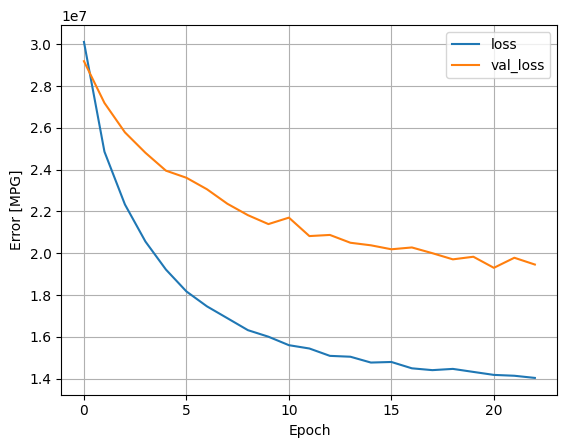

In [17]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

series = CreateSeriesDf()

df = series.drop(['date'], axis=1).copy()
df['dcoilwtico'] = fill_nan_with_nearest(df['dcoilwtico'])
# Droppo i nan, la perdita non è alta
df = df.dropna()
# Separo train validation e test
total = df.shape[0]
train = int(total * 0.7)
val = int(total * 0.2)
df_train = df.loc[:train]
df_val = df.loc[train:train+val]
df_test = df.loc[train+val:]

# I dati devono essere normalizzati. 
# La normalizzazione la calcolo sull'intera tabella
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df))
mean = normalizer.mean.numpy()
stddev = tf.sqrt(normalizer.variance).numpy()


w = WindowGenerator(input_width=6, label_width=1, shift=1, 
                    train_df = df_train, val_df=df_val, test_df = df_test, 
                    label_columns=['sales'])

for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

#You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten 
# as the first layer of the model
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='linear'),
])

MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, verbose=0,
                      callbacks=[early_stopping])
    return history

history = compile_and_fit(linear, w)
val_performance = {}
performance = {}
val_performance['model'] = linear.evaluate(w.val, return_dict=True)
performance['model'] = linear.evaluate(w.test, verbose=0, return_dict=True)
print(val_performance)
print(performance)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [18]:
print(linear.layers[1].kernel) #--> ha 156 pesi, questo perchè eseguo il flatten di un input bidimensionale (6 giorni e 26 features):
for input_to_linear, label_to_linear in w.train.take(1):
    print (input_to_linear.shape) #(32, 6, 26) --> 32 è il batch size, e 6*26 = 156

#np.array(linear.layers[1].kernel)

<KerasVariable shape=(156, 1), dtype=float32, path=sequential/dense/kernel>
(32, 6, 26)


Proviamolo in inferenza e paragoniamo al modello con **FOURIER**

In [19]:
def plotIdx(idx, df_train, df_val, df_test, model, model_fourier,X_fourier ):
    w = WindowGenerator(input_width=6, label_width=1, shift=1, 
                        train_df = df_train, val_df=df_val, test_df = df_test, 
                        label_columns=['sales'])

    in_data, lbl_data = w.split_data_for_tensor(df.loc[idx:idx+7], df.columns, ['sales'])
    predictions = model.predict(in_data)
    
    period_pred = slice(idx, idx+1)
    predictions_fourier = model_fourier.predict(X_fourier[period_pred])
    
    w.plot(in_data, lbl_data, prediction=predictions,predictions_fourier=predictions_fourier, n_subplots=1)

Costruisco un dictionary con tutte le previsioni per il modello lineare

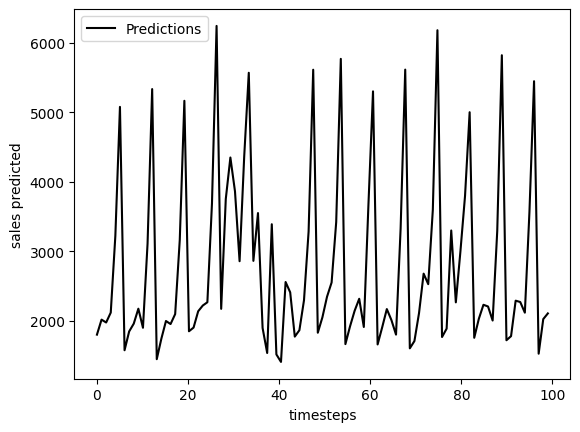

In [20]:
linear_predictions=[]
# Abbiamo 1704 righe tra train e test, quindi abbiamo un massimo di 1704 - 7 finestre = 1697
start=7
wide=100
for idx in range(start,start+wide):#1697
    in_data, lbl_data = w.split_data_for_tensor(df.loc[idx:idx+7], df.columns, ['sales'])
    linear_predictions.append(linear.predict(in_data, verbose=0))

x = tf.linspace(0, wide-1,wide-1)
indices = tf.cast(tf.round(x), tf.int32)
y = tf.gather(np.vstack(linear_predictions).flatten(), indices) 

def plot_predictions(x, y):
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('timesteps')
  plt.ylabel('sales predicted')
  plt.legend()

plot_predictions(x, y)


# Proviamo con le CONVOLUTION NEURAL NETWORK

per le serie temporali si utilizza un CONV1D.
* Il filtro utilizzato ha come prima dimensione la lunghezza temporale sulla quale si vuole farlo scorrere. Se la serie è multivariata allora il filtro avrà una seconda dimensione che corrisponde alla dimensione delle features
* in output lo strato convoluzionale genera un vettore di dimensioni minori/uguali a quello di entrata, a seconda del numero di iterazioni del filtro sulla dimensione sulla quale è applicato. Se si vogliono mantenere le dimensioni occorre applicare un padding


Inputs shape (batch, time, features): (32, 6, 26)
Labels shape (batch, time, features): (32, 1, 1)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16453669.0000 - mean_absolute_error: 2395.4458 
{'model': {'loss': 15618283.0, 'mean_absolute_error': 2302.25634765625}}
{'model': {'loss': 5989151.5, 'mean_absolute_error': 1849.3875732421875}}
17


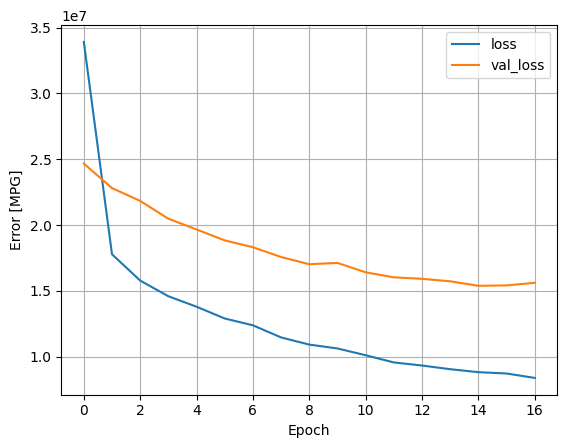

In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

series = CreateSeriesDf()

df = series.drop(['date'], axis=1).copy()
df['dcoilwtico'] = fill_nan_with_nearest(df['dcoilwtico'])
# Droppo i nan, la perdita non è alta
df = df.dropna()
# Separo train validation e test
total = df.shape[0]
train = int(total * 0.7)
val = int(total * 0.2)
df_train = df.loc[:train]
df_val = df.loc[train:train+val]
df_test = df.loc[train+val:]

w = WindowGenerator(input_width=6, label_width=1, shift=1, 
                    train_df = df_train, val_df=df_val, test_df = df_test, 
                    label_columns=['sales'])

for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

#You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten 
# as the first layer of the model
CONV_WIDTH = 2 #Il filtro su 6 giorni per catturare i pattern. in questo modo l'output sarà di 3. 
                # Possiamo effettuare un padding
conv1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,), #padding='same',
                           activation='relu'),
    tf.keras.layers.Flatten(), # Appiattisco prima di passare agli strati densi
    tf.keras.layers.Dense(1, activation='linear'),
])

MAX_EPOCHS = 400

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, verbose=0,
                      callbacks=[early_stopping])
    return history

history = compile_and_fit(conv1D, w)
val_performance = {}
performance = {}
val_performance['model'] = conv1D.evaluate(w.val, return_dict=True)
performance['model'] = conv1D.evaluate(w.test, verbose=0, return_dict=True)
print(val_performance)
print(performance)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)
print(hist.shape[0])

**Il risultato con le convolution neural networks è molto soddisfacente prendendo campioni casuali**

# Prova con RNN Recurrent neural network

Inputs shape (batch, time, features): (32, 6, 26)
Labels shape (batch, time, features): (32, 1, 1)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34908544.0000 - mean_absolute_error: 4133.3188 
{'model': {'loss': 35601944.0, 'mean_absolute_error': 4108.5205078125}}
{'model': {'loss': 4162767360.0, 'mean_absolute_error': 7859.07958984375}}
5


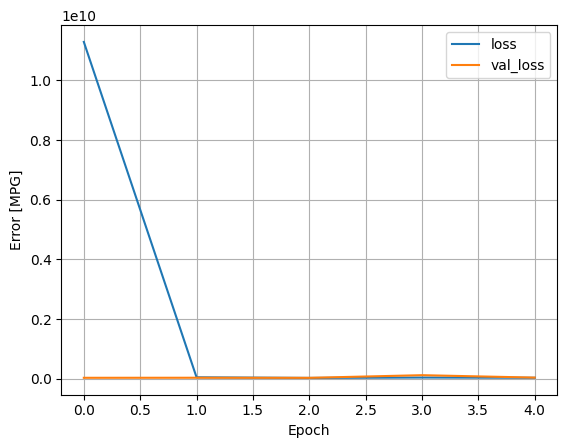

In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

series = CreateSeriesDf()

df = series.drop(['date'], axis=1).copy()
df['dcoilwtico'] = fill_nan_with_nearest(df['dcoilwtico'])
# Droppo i nan, la perdita non è alta
df = df.dropna()
# Separo train validation e test
total = df.shape[0]
train = int(total * 0.7)
val = int(total * 0.2)
df_train = df.loc[:train]
df_val = df.loc[train:train+val]
df_test = df.loc[train+val:]

w = WindowGenerator(input_width=6, label_width=1, shift=1, 
                    train_df = df_train, val_df=df_val, test_df = df_test, 
                    label_columns=['sales'])

for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(24, activation='relu', return_sequences=False),
    #tf.keras.layers.Flatten(), # Appiattisco prima di passare agli strati densi. Lo abilito nel caso return_sequences=True
    tf.keras.layers.Dense(1, activation='linear'),
])

MAX_EPOCHS = 400

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.50),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, verbose=0,
                      callbacks=[early_stopping])
    return history

history = compile_and_fit(lstm, w)
val_performance = {}
performance = {}
val_performance['model'] = lstm.evaluate(w.val, return_dict=True)
performance['model'] = lstm.evaluate(w.test, verbose=0, return_dict=True)
print(val_performance)
print(performance)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


print(hist.shape[0])
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


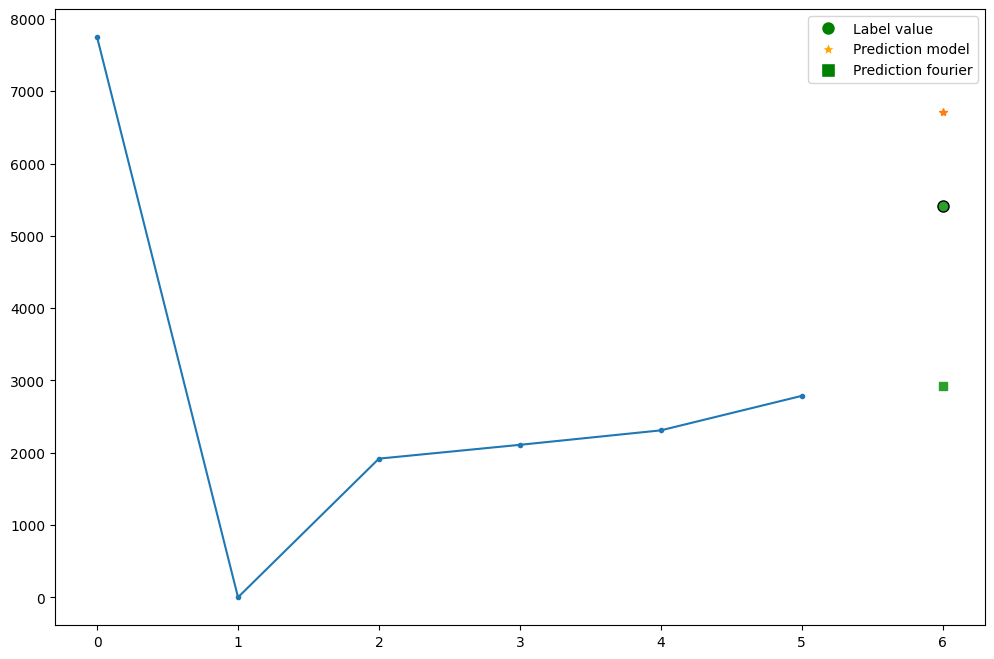

In [23]:
plotIdx(190, df_train, df_val, df_test, lstm, model_fourier,X_fourier)

# Costruiamo un df con le label e le predizioni per verificare qual è il migliore modello
naturalmente il confronto va fatto sui dati di validazione

In [24]:
series = CreateSeriesDf()

df = series.drop(['date'], axis=1).copy()
df['dcoilwtico'] = fill_nan_with_nearest(df['dcoilwtico'])
# Droppo i nan, la perdita non è alta
df = df.dropna()

total = df.shape[0]
train = int(total * 0.7)
val = int(total * 0.2)
df_train = df.loc[:train]
df_val = df.loc[train:train+val]
df_test = df.loc[train+val:]
